In [1]:
# general imports
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import warnings                         # to avoid warning - but be aware
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd                     # not yet fixed in 0.20 by anaconda
import statsmodels.formula.api as smf
import patsy


# GLM II - Modellvergleich
- Wiederholung *Lineare Modelle*
- Wiederholung Beispiel mit Daten
    - Gehirngewicht % Körpergewicht bei Säugetieren
- Residuen-Analyse
- Einfaches % Erweitertes Modell
- Kategoriale Daten
- Modell-Vergleich
    - t-Test des Parameters
    - F-Test des Modells
- Deviance
    - F-Test der Deviance
- Motivation GLM
- Ergebnis und Zusammenfassung

# Lineares Modell
$$\mathcal{E}(Y_i) = \mu_i = \mathbf{x}_i^T \boldsymbol\beta$$
$$Y_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

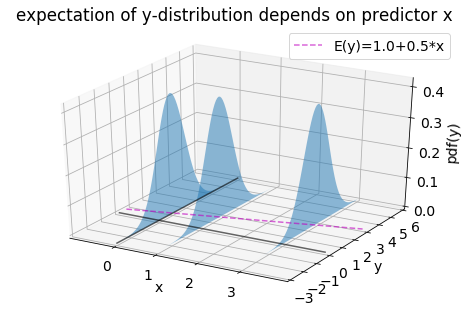

## Matrixdarstellung
$k$ unabhängige Variablen $X_j$ als Spalten der Länge $n$ in der **Designmatrix**

$$ \mathbf{X} = \begin{bmatrix} 
1      & X_{11} & X_{12} & \dots & X_{1k} \\
1      & X_{21} & X_{22} & \dots & X_{2k} \\
\vdots & \;     & \ddots & \;    & \vdots \\
1      & X_{n1} & X_{n2} & \dots & X_{nk}      \end{bmatrix}$$
**Parametervektor**
$$\boldsymbol\beta = \begin{bmatrix}\beta_0\\ \beta_1\\ \vdots \\\beta_k \end{bmatrix}$$

#### Lineares Modell

$$\mathcal{E}(\mathbf{Y}) = \boldsymbol\mu = \mathbf{X}\boldsymbol\beta$$
$$Y_i \sim f(Y;\boldsymbol\theta) \quad\text{z.B.}\quad \mathcal{N}(\mu, \sigma^2)$$

# Modellvergleich
Bsp: Allison, Cicchetti (1976) *Sleep in mammals: ecological and constitutional correlates.* Science **194:** 732-734 <br> http://www.statsci.org/data/general/sleep.html

In [3]:
'''
import the dataset from csv file (tab-separated) into a Pandas dataframe object:
'''
# tab-separated
animals = pd.read_csv('data/animals.txt', sep='\t')

'''
rescale weight because of spread: create new variable from linear data
'''
# new variable, converted from original data
animals['log_BodyWt'] = np.log10(animals['BodyWt'])
# new variable, converted from original data
animals['log_BrainWt'] = np.log10(animals['BrainWt'])
# focus on list of relevant data
animalsdata = animals[['log_BodyWt', 'log_BrainWt', 'Species']]
# drop lines with invalid data
animalsdata = animalsdata.dropna(axis=0)

'''
fit linear Gaussian (default) model with Patsy formula
'''
wfit = smf.glm(formula='log_BrainWt ~ log_BodyWt', data=animalsdata).fit()


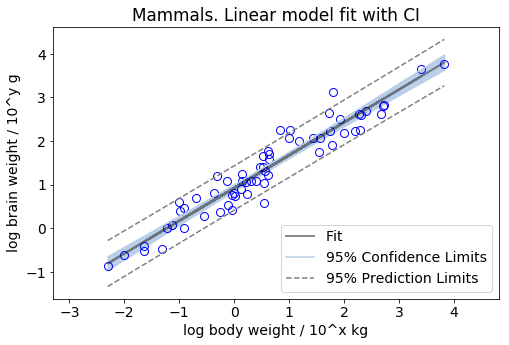

In [4]:
# get data
# extract independent variable
x = np.asarray(animalsdata['log_BodyWt'])
# extract dependent variable
y = np.asarray(animalsdata['log_BrainWt'])
# estimated linear result
y_hat = np.asarray(wfit.fittedvalues)
x_bar = x.mean()

# Statistics
# used for CI and PI bands according to residua's degree-of-freedom
t = stats.t.ppf(0.95, wfit.df_resid)

# Estimates of Error in Data/Model
# standard deviation of the error
s_err = np.sqrt(np.sum(wfit.resid_response**2)/(wfit.df_resid))

fig = plt.figure(figsize=(8,5))
# show data
plt.plot(x, y,'o', color='#b9cfe7', markersize=8,
         markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')
# show fit
plt.plot(x, y_hat,'-', color='0.1', linewidth=2, alpha=0.5, label='Fit')

x2 = np.linspace(np.min(x), np.max(x), 100)
# IF SLEEP: reverse due to decrease
y2 = np.linspace(np.min(y_hat), np.max(y_hat), 100)

# confidence interval
CI = t*s_err*np.sqrt(1/len(x) +(x2-x_bar)**2/np.sum((x-x_bar)**2))
plt.fill_between(x2, y2+CI, y2-CI, color='#b9cfe7', edgecolor='')
# Minor hack for labeling CI fill_between()
plt.plot(x2, y2+CI, '-', color='#b9cfe7', label='95% Confidence Limits')

# Prediction Interval
PI = t*s_err*np.sqrt(1+1/len(x)+(x2-x_bar)**2/np.sum((x-x_bar)**2))
plt.fill_between(x2, y2+PI, y2-PI, color='None', linestyle='--')
plt.plot(x2, y2-PI, '--', color='0.5', label='95% Prediction Limits')
plt.plot(x2, y2+PI, '--', color='0.5')

# Labels
plt.title('Mammals. Linear model fit with CI')
plt.xlabel('log body weight / 10^x kg')
plt.ylabel('log brain weight / 10^y g')
plt.legend(loc='lower right')
plt.xlim(np.min(x)-1,np.max(x)+1);


## Interessant: Abweichungen vom Modell
- Systematisch? 
- Zufall (wie im Modell vorgesehen)?


In [5]:
'''
predicted values
'''
# selected
table = pd.concat([animalsdata[['Species', 'log_BrainWt']], wfit.fittedvalues], axis=1)
# hack: rename the new noname Series [0]column
table.rename(columns = {0:'fitted'}, inplace = True)
print(table.head(6))


                  Species  log_BrainWt    fitted
0         Africanelephant     3.756788  3.800885
1  Africangiantpouchedrat     0.819544  0.927127
2               ArcticFox     1.648360  1.325189
3    Arcticgroundsquirrel     0.755875  0.899907
4           Asianelephant     3.663041  3.487391
5                  Baboon     2.254064  1.696291


In [6]:
'''residua'''
table = pd.concat([table, wfit.resid_response], axis=1) # attach residua
table.rename(columns = {0:'residuum'}, inplace = True)  # hack to rename column
print(table.head(6))


                  Species  log_BrainWt    fitted  residuum
0         Africanelephant     3.756788  3.800885 -0.044096
1  Africangiantpouchedrat     0.819544  0.927127 -0.107583
2               ArcticFox     1.648360  1.325189  0.323171
3    Arcticgroundsquirrel     0.755875  0.899907 -0.144032
4           Asianelephant     3.663041  3.487391  0.175650
5                  Baboon     2.254064  1.696291  0.557773


#### Ausreißer nach oben

In [8]:
'upper outliers(?)'
print(table.sort_values(by='residuum', ascending=False).head(8))


           Species  log_BrainWt    fitted  residuum
33             Man     3.120574  2.274443  0.846131
49    Rhesusmonkey     2.252853  1.552912  0.699941
5           Baboon     2.254064  1.696291  0.557773
41       Owlmonkey     1.190332  0.687520  0.502811
9       Chimpanzee     2.643453  2.218025  0.425427
26  Groundsquirrel     0.602060  0.178689  0.423371
42     Patasmonkey     2.060698  1.678813  0.381885
59          Vervet     1.763428  1.394836  0.368592


## Ergebnis Residuen-Analyse
- **Systematische** Abweichungen
    - Ausreißer, Auffälligkeit
    - Affen haben positive Residuen: eher *kein Zufall*
- **Zufällige** Abweichungen
    - Verteilung gemäß Modell: Streuung

# Erweitertes Modell
#### [Affen] [andere Säugetiere]

In [11]:
'''
distinguish monkeys from other mammals
'''
# create new variable in dataframe
animalsdata['IsMonkey']='no'
# list of old world monkeys
pnames = ['Man', 'Baboon', 'Chimpanzee', 'Gorilla', 'Owlmonkey', 
          'Patasmonkey', 'Rhesusmonkey', 'Galago' ]
# locate and change
animalsdata.loc[animalsdata['Species'].isin(pnames), 'IsMonkey'] = 'yes'


In [13]:
'''
enhanced linear model: monkeys ------v  separated from other mammals
'''
mfit = smf.glm(
    formula='log_BrainWt ~ IsMonkey + log_BodyWt', data=animalsdata).fit() 


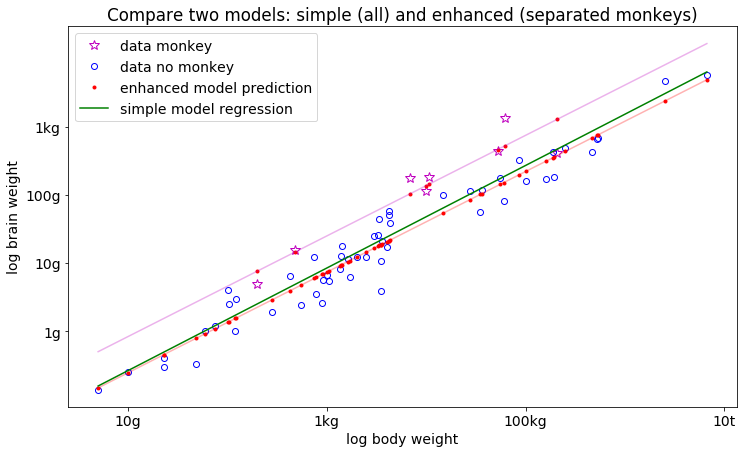

In [14]:
'''
result of enhanced linear model: log(body weight) ~ log(brain weight) + IsMonkey
'''

# regression line y = f(x) = beta0+beta1*x  with parameters beta[] at value x
def f(x, b):
    return b[0] + b[1]*x

'''
show linear dependency for    log(body weight) ~ log(brain weight)
'''

fig = plt.figure(figsize=(12,7))
# show data
plt.plot(animalsdata['log_BodyWt'].loc[animalsdata['IsMonkey']=='yes'], 
         animalsdata['log_BrainWt'].loc[animalsdata['IsMonkey']=='yes'],
         '*', label='data monkey', markeredgewidth=1,markeredgecolor='m', 
         markerfacecolor='None', markersize=10)

plt.plot(animalsdata['log_BodyWt'].loc[animalsdata['IsMonkey']=='no'], 
         animalsdata['log_BrainWt'].loc[animalsdata['IsMonkey']=='no'],
         'o', label='data no monkey', markeredgewidth=1,markeredgecolor='b',
         markerfacecolor='None')

plt.plot(animalsdata['log_BodyWt'], mfit.fittedvalues, 'r.',
         label='enhanced model prediction')
x_ = np.asarray([animalsdata['log_BodyWt'].max(),
                 animalsdata['log_BodyWt'].min()])

# skip beta1: non-monkeys 
plt.plot(x_, f(x_, mfit.params[::2]), 'r-', alpha=.3)
# with beta1 as extra offset
plt.plot(x_, f(x_, (mfit.params[:2].sum(), mfit.params[2])), 'm-', alpha=.3)

xs = np.asarray([animalsdata['log_BodyWt'].min(), animalsdata['log_BodyWt'].max()])
# beta_hat = 

# from linear fit through complete data set
ys = f(xs, wfit.params)
# straight line through extreme points
plt.plot(xs, ys, 'g-', label='simple model regression')

# Labels
plt.title('Compare two models: simple (all) and enhanced (separated monkeys)')
plt.xticks([-2, 0, 2, 4], ['10g', '1kg', '100kg', '10t'])
plt.yticks([0, 1, 2, 3], ['1g', '10g', '100g', '1kg'])
plt.xlabel('log body weight')
plt.ylabel('log brain weight')
plt.legend(loc='upper left');


                 Generalized Linear Model Regression Results                  
    ==============================================================================
    Dep. Variable:            log_BrainWt   No. Observations:                   62
    Model:                            GLM   Df Residuals:                       60
    ==============================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
    ------------------------------------------------------------------------------
    Intercept      0.9271      0.042     22.227      0.000       0.845       1.009
    log_BodyWt     0.7517      0.028     26.409      0.000       0.696       0.807
    ==============================================================================


                 Generalized Linear Model Regression Results                  
    ==============================================================================
    Dep. Variable:            log_BrainWt   No. Observations:                   62
    Model:                            GLM   Df Residuals:                       59
    ==============================================================================
                        coef   std err          z    P>|z|      [0.025      0.975]
    ------------------------------------------------------------------------------
    Intercept         0.8670     0.035     24.496    0.000       0.798       0.936
    IsMonkey[T.yes]   0.5303     0.093      5.698    0.000       0.348       0.713
    log_BodyWt        0.7374     0.023     31.802    0.000       0.692       0.783
    ==============================================================================

## Kategoriale Variablen

Anpassen der Designmatrix

In [17]:
'''
patsy automagically creates a design matrix for linear model brain
weight vs. body weight and flag monkey
'''
y, X = patsy.dmatrices('log_BrainWt ~ log_BodyWt + IsMonkey', animalsdata)
print(X[:7], '... design matrix X: intercept + independent data')
print(y[:7], '... response vector y: dependent data')


[[ 1.          0.          3.8230828 ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.52955867]
 [ 1.          0.         -0.03621217]
 [ 1.          0.          3.40602894]
 [ 1.          1.          1.02325246]
 [ 1.          0.         -1.63827216]] ... design matrix X: intercept + independent data
[[ 3.7567882 ]
 [ 0.81954394]
 [ 1.64836001]
 [ 0.75587486]
 [ 3.66304097]
 [ 2.25406445]
 [-0.52287875]] ... response vector y: dependent data


#### Indikatorvariable $c$ für Kategorien *IsMonkey='no'* ${\;\color{blue}{0}}\;$ und *IsMonkey='yes'* $\;{\color{magenta}{1}}$

$$\begin{align}
\mathcal{E}(\mathbf{Y}) \quad &= \quad \mathbf{X} \quad \boldsymbol{\beta} \quad \\
\mathcal{E}(Y_i) \quad &= 1\cdot\beta_0 + c_i\cdot {\color{red}{\beta_1}} + X_i\cdot\beta_2\\
\begin{bmatrix}
{\color{blue}{Y_1}} \\ \vdots \\ {\color{blue}{Y_a}} \\ {\color{magenta}{Y_{a+1}}} \\ \vdots \\ {\color{magenta}{Y_n}} 
\end{bmatrix} \quad &= 
\begin{bmatrix} 
1  & {\color{blue}{0}} & {\color{blue}{X_1}} \\ \vdots & \vdots & \vdots \\ 1 & {\color{blue}{0}} & {\color{blue}{X_a}}    \\
1 & {\color{magenta}{1}} & {\color{magenta}{X_{a+1}}} \\ \vdots & \vdots & \vdots \\ 1 & {\color{magenta}{1}}    & {\color{magenta}{X_n}}    \end{bmatrix}
\begin{bmatrix}\beta_0\\ {\color{red}{\beta_1}}\\ \beta_2 \end{bmatrix} 
\end{align}$$


## Ergebnis Kategoriale Variable
- wirkt als Schalter 
    - Wert $X_{ij} \in [0, 1]$
    - für Parameter $\beta_j$
- Kategorien werden von *Patsy* automatisch erkannt (zB. wenn *String*)
    - erzwingen mit `'C(variable)'`
- fügt sich formal in Lineares Modell ein
- erweiterbar auf mehrere Ausprägungen
    - mehrere Spalten 
        - (*nicht Zahlen*! [**ÜA**] Bitte klar machen)

## Vergleich: Residuen der beiden Modelle
- Modell A: $r_{Ai} = y_i - \widehat\mu_{Ai} = y_i - (\mathbf{X}_A\widehat{\boldsymbol\beta}_A)_i$
- Modell B: $r_{Bi} = y_i - \widehat\mu_{Bi} = y_i - (\mathbf{X}_B\widehat{\boldsymbol\beta}_B)_i$

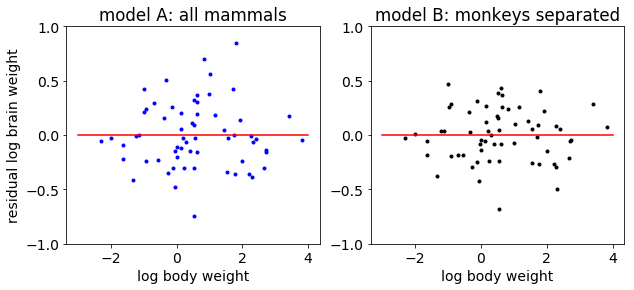

In [18]:
'''
log brain weights residua
'''
fig = plt.figure(figsize=(10, 4))
titles = ['model A: all mammals', 'model B: monkeys separated']

'''
for each model (all animals / monkeys separated) a scatter plot
'''
for i, (fit, col) in enumerate(zip([wfit, mfit], ['b', 'k'])):
    # subplots 1 and 2
    fig.add_subplot(1, 2, i+1)
    # scatter of residua
    plt.plot(animalsdata['log_BodyWt'], fit.resid_response, col+'.')
    # zero line
    plt.plot([-3., 4.], 2*[0], 'r-')
    plt.ylim(-1, 1)
    plt.xlabel('log body weight')
    if i==0:
        # ylabel is same, only left
        plt.ylabel('residual log brain weight')
    plt.title(titles[i])
    

A all mammals       residual skew =  0.416
B separated monkeys residual skew = -0.227


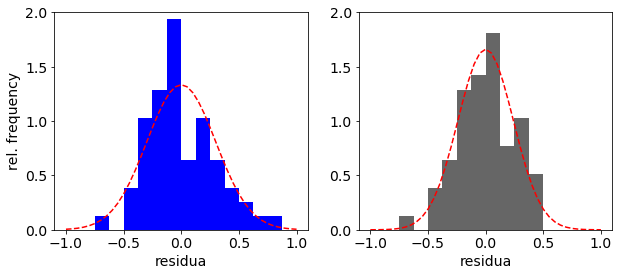

In [19]:
'''
log brain weights residua distribution
'''
fig = plt.figure(figsize=(10, 4))
bins=np.linspace(-1., 1., 17)
x = np.linspace(-1., 1., 41)

'''
for each model (all animals / monkeys separated) a histogram
'''
for i, (fit, col) in enumerate(zip([wfit, mfit], ['b', 'k'])):
    # subplots 1 and 2
    fig.add_subplot(1, 2, i+1)
    # colored, transparent, same scale
    plt.hist(fit.resid_response, bins, color=col,
             alpha=1-i*.4, normed=True)
    # estimated distribution
    mu, sigma = (fit.resid_response.mean(), fit.resid_response.std())
    # ... as Gaussian graphics
    plt.plot(x, stats.norm(mu, sigma).pdf(x), 'r--')
    plt.xlabel('residua')
    # make both the same height
    plt.ylim(0.0, 2.0)
    if i==0:
        plt.ylabel('rel. frequency')

print('A all mammals       residual skew = {:6.3f}'.format(wfit.resid_response.skew()))
print('B separated monkeys residual skew = {:6.3f}'.format(mfit.resid_response.skew()))


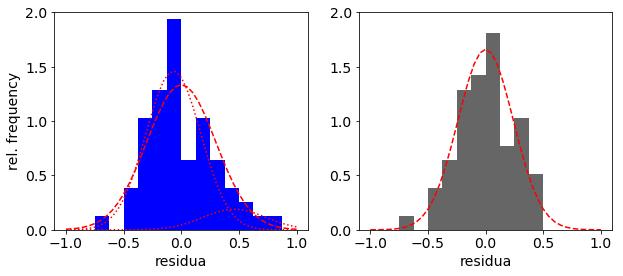

In [20]:
'''
log brain weights residua distribution - Model A bimodal? -> Model B
'''
fig = plt.figure(figsize=(10, 4))
bins=np.linspace(-1., 1., 17)
x = np.linspace(-1., 1., 41)
# residua of monkeys
rym = mfit.resid_response[animalsdata['IsMonkey']=='yes']
# residua of non-monkeys
ryn = mfit.resid_response[animalsdata['IsMonkey']!='yes']
# weighted center of category monkey
murm = mfit.params[1]*ryn.size/(ryn.size+rym.size)
# ... and category non-monkey within model both
murn = -mfit.params[1]*rym.size/(ryn.size+rym.size)

'''
for each model (all animals / monkeys separated) a histogram
'''
for i, (fit, col) in enumerate(zip([wfit, mfit], ['b', 'k'])):
    # subplots 1 and 2
    fig.add_subplot(1, 2, i+1)
    # colored, transparent, same scale
    plt.hist(fit.resid_response, bins, color=col,
             alpha=1-i*.4, normed=True)
    # estimated distribution
    mu, sigma = (fit.resid_response.mean(), fit.resid_response.std())
    # ... as Gaussian graphics
    plt.plot(x, stats.norm(mu, sigma).pdf(x), 'r--')
    plt.xlabel('residua')
    # make both the same height
    plt.ylim(0.0, 2.0)
    if i==0:
        plt.ylabel('rel. frequency')
        # Gauss monkey
        plt.plot(x, rym.size/(ryn.size+rym.size)*stats.norm(murm, rym.std()).pdf(x), 'r:')
        # Gaus other
        plt.plot(x, ryn.size/(ryn.size+rym.size)*stats.norm(murn, ryn.std()).pdf(x), 'r:')
        

## Zusammenfassung Residuen
- Gehören zu einem Modell
- Minimieren
    - Kleinste-Quadrate
    - Matrix Zerlegung
    - Maximum-Log-Likelihood
- Überprüfen, ob Modellvoraussetzungen erfüllt sind
    - Scatter-Plot
    - Histogramm

# Fragen?

# Modell-Vergleich

### Quadratfehlersumme, *sum of squared residua, RSS*
$$RSS= \sum_{i=1}^n r_i^2 = \sum_{i=1}^n (y_i - (\mathbf{X}\widehat{\boldsymbol\beta})_i)^2$$

- Ist eine charakteristische Kennzahl
    - Für Gauß-Verteilungen: standardisierte Quadratfehlersumme $\tilde{S}=\frac{RSS}{\sigma^2}$
    - $\tilde{S} \sim \chi^2(n-p)$ 
- Abhängigkeiten nur von
    - $n$ Werten der *abhängigen* Variablen
    - $n$ Werten der *unabhängigen* Variablen
    - $p$ geschätzte Parameterwerte
- je kleiner $RSS$, desto näher liegt das Modell an den Daten

#### Schätzer für $\boldsymbol\beta$
$\widehat{\boldsymbol\beta}$ aus Max-Likelihood oder Kleinste-Quadtrate ($k$ Komponenten)

#### Schätzer für $\boldsymbol\mu$
$\widehat\mu_i = \mathbf{X}^T_i \widehat{\boldsymbol\beta}$ aus dem linearen Modell

#### Schätzer für *Störparameter* $\sigma^2$
Seien $y_i$ *Normalverteilt* (mindestens näherungsweise; Zentraler Grenzwertsatz), dann ist mit
$$RSS= \sum_{i=1}^N r_i^2 = \sum_{i=1}^N (y_i - (\mathbf{X}\widehat{\boldsymbol\beta})_i)^2$$
$$\widehat\sigma^2 = \frac{1}{N-k}RSS$$
ein erwartungstreuer Schätzer der Varianz $\sigma^2$ für das *Lineare Modell* 
$$\mathcal{E}(\mathbf{Y}) = \mathbf{X}\boldsymbol\beta\qquad Y_i\sim\mathcal{N}(\mu_i,\sigma^2)$$
mit $k$ Parametern bzw. $N-k$ Freiheitsgraden für die Residuen

$$\widehat\sigma^2 = \frac{1}{N-k}\sum_{i=1}^N r_i^2 =  \frac{1}{N-k} \sum_{i=1}^N (y_i - (\mathbf{X}\widehat{\boldsymbol\beta})_i)^2$$

#### Verteilung der standardisierten Fehlerquadratsumme
$$ \frac{RSS}{\sigma^2} \sim \chi^2(N\!-\!k)$$

Die Verteilung der Zufallsvariable *Schätzer der Residuen-Varianz* $\widehat\sigma^2$ ist dann skaliert:
$$ \widehat \sigma^2 \sim \chi^2(\mathtt{df}\!=\!N\!-\!k,\; \mathtt{scale}\!=\!\frac{\sigma^2}{N})$$

*... unter der Nullhypothese, daß das Modell korrekt ist*!

#### Problem 1
Woher kennen wir das wahre $\sigma^2$?

#### Problem 2
Was ergibt die Berechnung mit dem Schätzer?

#### Vergleich der beiden Modelle
Voraussetzung: Modelle bauen aufeinander auf, Modell B ist eine Erweiterung/Verallgemeinerung des einfacheren Modells A

- Ist Modell B (hier $k_B = 3$ Parameter) angemessen?
    - Nein $\;\Rightarrow\;$  beide Modelle verwerfen
    - Ja $\;\Rightarrow\;$ vergleiche mit Modell A
- Ist Modell A (hier $k_A = 2$ Parameter) angemessen?
    - Nein $\;\Rightarrow\;$ wähle Modell B
    - Ja $\;\Rightarrow\;$ Vergleich mit Modell B ergibt ...

#### Statistiken ...

## Gauß-Test / t-Test
Neue Differenz in Kategorien = Zusätzlicher Parameter

- Modellannahme
- Nullhypothese: Parameter `IsMonkey` ist nicht nötig, Einfluß $\beta_1 = 0$
    - Alternativhypothese: `IsMonkey` ist relevant, Einfluß $\beta_1 \neq 0$
- Teststatistik standardisierte Differenz - *Gauß-Test* für $\beta_{IsMonkey}$
$$Z = \frac{\overline{X_a}-\overline{X_b}}{\sqrt{S^2_a/n_a+S^2_b/n_b}} \sim \mathcal{N}(0,1) = \varphi$$    
- Verwerfungsbereich festlegen und bestimmen
    - Zur Irrtumswahrscheinlichkeit $\alpha=0.1\%$
- Wert der Statistik berechnen, p-Wert
- Ergebnis und Entscheidung

In [22]:
'''
ask fit for statistics and significance
'''
i = 1        # index 2nd parameter beta[1]
print('Gauß-test of beta[{}] ({}) gives z={:.4f} with p-value={:.9f}'
      .format(i, list(dict(mfit.params).keys())[i-1], mfit.tvalues[i], mfit.pvalues[i]))


Gauß-test of beta[1] (Intercept) gives z=5.6980 with p-value=0.000000012


#### Problem
Kummulierter $\alpha$-Fehler

## Unterschied in den Varianzen der Modelle?
### F-Test
Vergleich des Varianzverhältnisses unter der Voraussetzung $\chi^2$-*Verteilung* der Residuen

$$ F = \frac{SQE/({n_c}-1)}{SQR/(n-{n_c})} \sim\mathcal{F}(n_c\!-\!1, n\!-\!n_c)$$

**[ÜA]** Vergleiche Varianzanalyse *ANOVA*

In [25]:
'''
ANOVA of separated categories within enhanced model B
'''
# residua of monkeys
rmi = mfit.resid_response[animalsdata['IsMonkey']=='yes']
# residua of non-monkeys
rni = mfit.resid_response[animalsdata['IsMonkey']!='yes']
# difference between categories
diff = mfit.params[1]
# Test this difference
F, pF = stats.f_oneway(rni, rmi+diff)
print('Comparison of categories in enhanced model')
print(' F-test  F={:8.5f} has p-value={:.9f}'.format(F, pF))


Comparison of categories in enhanced model
 F-test  F=33.40666 has p-value=0.000000286


In [26]:
'''
restrict model and compare to original enhanced model
'''
# set beta[1] (the monkey-categorie's offset) to test for
restriction = [0, 1, 0]
print('Comparison of enhanced model vs. restricted model')
print(mfit.f_test(restriction))


Comparison of enhanced model vs. restricted model
<F test: F=array([[ 32.46757181]]), p=4.0758485253144104e-07, df_denom=59, df_num=1>


## Vergleich der Likelihood

Verhältnis der Likelihood $\; = \frac{L_A}{L_B}$

Differenz der Log-Likelihood $\; = log(L_A) - log(L_B) = l_A-l_B$

#### Maximal mögliche Likelihood?
"Vollständiges" Modell $\widehat{y}_i \equiv y_i\;$ mit Likelihood $\;L_V$

#### Deviance
(Doppelter) Unterschied zur Log-Likelihood des *vollständigen* Modells
$$D := 2(l_V - l_A)$$

# Deviance
Voraussetzung: Modelle bauen aufeinander auf

Definition
$$D(\widehat{\boldsymbol\theta};\mathbf{y}) := 2\bigl(l(\tilde{\boldsymbol\theta};\mathbf{y}) - l(\widehat{\boldsymbol\theta};\mathbf{y})\bigr)$$

- $\mathbf{y}$ Werte der abhängigen Variable
- $\widehat{\boldsymbol\theta}$ Schätzer der Parameter
- $\tilde{\boldsymbol\theta}$ Schätzer der Parameter eines *vollständigen* Modells $\widehat{y}_i \equiv y_i$

### Beispiel  Lineares Modell mit Normalverteilung(en)
$$l(\boldsymbol\mu;\mathbf{y}) = -\frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i-\mu_i)^2-n\log{(\sigma\sqrt{2\pi})}$$
$$\begin{align}
D &= 2\bigl(l(\tilde{\boldsymbol\mu};\mathbf{y}) - l(\widehat{\boldsymbol\mu};\mathbf{y})\bigr) \\
  &= \frac{1}{\sigma^2}\sum_{i=1}^{n}(y_i-\widehat\mu_i)^2
\end{align}$$
entspricht damit Pearsons standardisierter Quadratfehlersumme, also  
$$D \sim \chi^2(n-k)$$

Begründung: Abhängigkeiten der $\boldsymbol\mu = \mathbf{X}\boldsymbol\beta$, es verbleiben $k$ Komponenten, Freiheitsgrade in $\boldsymbol\beta$

#### Streuung $\sigma$ ist unbekannt
Die angegebene *scaled Deviance* ist aus den Daten berechenbar
$$D' = \sigma^2 D = \sum_{i=1}^{n}(y_i-\mu_i)^2$$ 

http://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.Gaussian.deviance.html

In [27]:
'''
fit() calculates scaled deviances
'''
print("scaled deviance D' of simple model       'all animals'       = {:.3f}".format(
    wfit.deviance))
print("scaled deviance D' of more general model 'separated monkeys' = {:.3f}".format(
    mfit.deviance))


scaled deviance D' of simple model       'all animals'       = 5.455
scaled deviance D' of more general model 'separated monkeys' = 3.519


In [28]:
'''
transform scaled to non-scaled deviance
'''
# estimate sigma from (better, good?) model
sigma2hat = 1./mfit.df_resid*(mfit.resid_response**2).sum()
print("deviance D of simple model       'all animals'       = {:.3f}".format(
    wfit.deviance/sigma2hat))
print("deviance D of more general model 'separated monkeys' = {:.3f}".format(
    mfit.deviance/sigma2hat))


deviance D of simple model       'all animals'       = 91.468
deviance D of more general model 'separated monkeys' = 59.000


## Unterscheiden sich die beiden Modelle?


### Unterschied in Deviance $\Delta D$:
$$\Delta D (\widehat{\boldsymbol\theta}_A, \widehat{\boldsymbol\theta}_B;\mathbf{y}) = D (\widehat{\boldsymbol\theta}_A;\mathbf{y}) -D (\widehat{\boldsymbol\theta}_B;\mathbf{y}) = 2l(\widehat{\boldsymbol\theta}_B;\mathbf{y}) - 2l(\widehat{\boldsymbol\theta}_A;\mathbf{y})>0$$

- $\mathbf{y}$ Werte der abhängigen Variable
- $\widehat{\boldsymbol\theta}_A$ Schätzer der Parameter ($k_A$ Stk.) des einfachen Modells
- $\widehat{\boldsymbol\theta}_B$ Schätzer der Parameter ($k_B$ Stk.) des erweiterten Modells
- $\Delta D\geq 0$
- Verteilung
$$\Delta D \sim \chi^2(k_B-k_A)$$

In [30]:
'''
is there a significant difference in deviances?
'''
# enhanced model, monkeys separated, 3 parameters
DA = wfit.deviance/sigma2hat
# simple model: all animals, 2 parameters
DB = mfit.deviance/sigma2hat
# number of parameters (3)
kA = len(wfit.params)
#                      (2)
kB = len(mfit.params)
deltaD = DA-DB
pD = 1 - stats.chi2(kB-kA).cdf(deltaD)
print('The difference in deviances={:.3f} with ddof={:2} has a p-value of {:.9f}'
      .format(deltaD, kB-kA, pD))


The difference in deviances=32.468 with ddof= 1 has a p-value of 0.000000012


### Fisher $\mathcal{F}$-Test für Deviance
Betrachte das Verhältnis
$$F = \frac{D_A-D_B}{k_B-k_A} \Big{/} \frac{D_B}{n-k_B} \sim \mathcal{F}(k_B-k_A, n-k_B)$$

In [31]:
F = (wfit.deviance-mfit.deviance)/(kB-kA)/mfit.deviance*(n-kB)
pF = 1-stats.f(kB-kA, n-kB).cdf(F)
print('''Difference in Deviances with {:1d} 
additional parameter gives Fisher F={:.3f} with p-value={:.9f}
      '''.format(kB-kA, F, pF))


Difference in Deviances with 1 additional parameter gives Fisher F=32.468 with p-value=0.000000408


## Frage: Unterschied?

**Nullhypothese**: Modell A (alle Säugetiere) ist ebenso gut wie das bessere Modell B (Affen getrennt)<br>
**Alternativhypothese**: Modell B beschreibt den linearen Zusammenhang besser

## Ergebnis
Der Unterschied ist höchst signifikant ($\alpha=0.1\%$)
- t-Test/Gauß-Test für Parameter $\beta_{\text{IsMonkey}}$
- Varianzanalyse für Residuen zwischen beiden Modellen
- F-Test der Deviance zwischen beiden Modellen

$\Rightarrow$ Das erweiterte Modell mit kategorialer Unterscheidung (einem Parameter mehr) ist angemessen.

# Zusammenfassung Deviance
- sinnvoll für Modellvergleich
    - Modelle müssen aufeinander aufbauen (*hierarchical*)
    - Grund: Verteilung der Likelihood je nach Modell, nicht absolut
    - passend für alle Wahrscheinlichkeitsverteilungen aus der Exponentialfamilie
- entspricht bei Normalverteilung der standardisierten Quadratfehlersumme
    - Verteilung $\sim \chi^2(k)$ mit Anzahl der *zusätzlichen* Parameter $k$ zum erweiterten Modell
- auch für andere Verteilungen
    - näherungsweise $\chi^2$-verteilt
- Unterschied in Deviance
    - in guter Näherung $\chi^2$-verteilt

# Fragen?

# Motivation *Generalisiertes* Lineares Modell


### Problemstellung
Jet-Piloten erfahren unter besonders hohen Beschleunigingskräften (bezogen auf die Erdbeschleuniging $g$) Blackouts.

#### Versuch
Glaister und Miller (1990) erzeugten ähnliche Symptome, indem sie den Körper der Versuchspersonen einem Luftunterdruck aussetzten. Daten von hier: http://www.statsci.org/data/general/gforces.html

#### Fragestellung
Hängt die Ohnmacht vom Alter ab?

In [2]:
gf = pd.read_csv('data/gforces.txt', sep='\t')
print(gf)


  Subject  Age  Signs
0      JW   39      0
1      JM   42      1
2      DT   20      0
3      LK   37      1
4      JK   20      1
5      MK   21      0
6      FP   41      1
7      DG   52      1


    Variable  Description
	Subject   Initials of the subject's name
	Age       Subject's age in years
	Signs     Whether subject showed blackout-related signs (0=No, 1=Yes)

In [3]:
'''a LINEAR fit of symptoms ~ age'''
fit_gf_linear = smf.glm('Signs ~ Age', gf).fit()
print(fit_gf_linear.summary())


                  Generalized Linear Model Regression Results                  
Dep. Variable:                  Signs   No. Observations:                     8
Model:                            GLM   Df Residuals:                         6
Model Family:                Gaussian   Df Model:                             1
Link Function:               identity   Scale:              0.23433462532299743
Method:                          IRLS   Log-Likelihood:                 -4.3968
Date:                Fri, 25 May 2018   Deviance:                        1.4060
Time:                        16:54:05   Pearson chi2:                      1.41
No. Iterations:                     2                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0998      0.540     -0.185      0.853      -1.159       0.959
Age            0.0213      0.015      1.415

xdata:
---
0    39
1    42
2    20
3    37
4    20
5    21
6    41
7    52
Name: Age, dtype: int64

ydata:
----
0    0
1    1
2    0
3    1
4    1
5    0
6    1
7    1
Name: Signs, dtype: int64

xpredict:
-----
   Age
0    0
1   70

ypredict:
-----
0   -0.099806
1    1.392442
dtype: float64



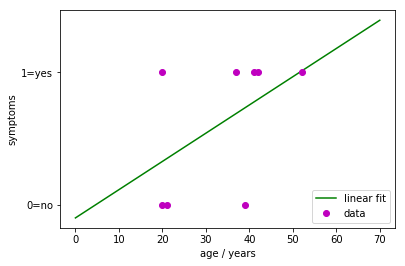

In [13]:
'''show predicted values of symptoms'''
xdata = gf['Age']
ydata = gf['Signs']
xpredict = pd.DataFrame({'Age': [0, 70]})
ypredict = fit_gf_linear.predict(xpredict)
# 测试
print('xdata:\n---\n{}\n\nydata:\n----\n{}\n'
     .format(xdata, ydata))
print('xpredict:\n-----\n{}\n\nypredict:\n-----\n{}\n'.format(xpredict, ypredict))
# 画图
plt.plot(xpredict, ypredict, 'g-', label='linear fit')
plt.plot(xdata, ydata, 'mo', label='data')
plt.xlabel('age / years')
plt.ylabel('symptoms')
plt.yticks([0., 1.], ['0=no', '1=yes'])
plt.legend(loc='lower right');


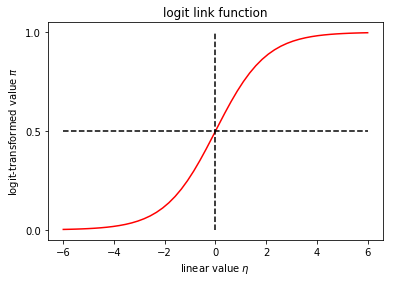

In [18]:
'''the logit function restricts y within 0..1'''
# logit = \frac{1}{1 + e^(-x)}
def logit(x):
    return(1. / (1. + np.exp(-x)))

x_ = np.linspace(-6, 6) # a linear predictor
y_ = logit(x_)  # transformed and restrained
# 画图
plt.plot(x_, y_, 'r-')
plt.plot([0, 0], [0, 1], 'k--')
plt.plot([-6, 6], [0.5, 0.5], 'k--')
plt.yticks([0, 0.5, 1])
plt.xlabel('linear value $\eta$')
plt.ylabel('logit-transformed value $\pi$')
plt.title('logit link function');


## Lösung *Logit-Link*
- Wahrscheinlichkeit des Bernoulli-Ereignisses $\pi \in [0\dots 1]$
- Linearer Term $\boldsymbol\eta = \mathbf{X}\boldsymbol\beta$

#### Link-Funktion **logit**
$$\mathcal{E}(\mathbf{Y}) = \boldsymbol\pi \qquad g(\boldsymbol\pi) = \boldsymbol\eta = \mathbf{X}\boldsymbol\beta$$

$$\mathcal{E}(\mathbf{Y}) = \boldsymbol\pi = g^{-1}(\mathbf{X}\boldsymbol\beta)$$

#### logit-Funktion 
$$g^{-1}(\eta) = \text{logit}(\eta) = \frac{1}{1+e^{-\eta}}$$

#### Umkehrfunktion: logarithmisches Chancenverhältnis *log-odds-ratio*
$$\eta = g(\pi) = \ln\frac{\pi}{1-\pi}$$

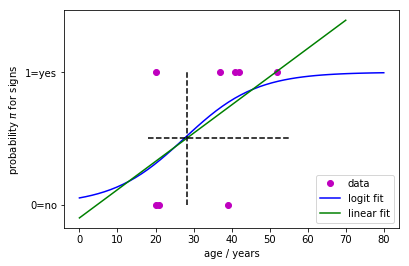

In [19]:
'''the logit function restricts y within 0..1'''
# logit = \frac{1}{1 + e^{-x}}
def logit(x): # the general logit function
    return(1. / (1. + np.exp(-x)))

xa = np.linspace(0, 80) # ages
ya = logit(-2.92 + .106*xa) # transformed and restrained

# 画图
plt.plot(xdata, ydata, 'mo', label='data') # data points
plt.plot(xa, ya, 'b-', label='logit fit')  # a fitting logit curve
# and the linear predictor
plt.plot(xpredict, ypredict, 'g-', label='linear fit')
# reversed linear regression for age of 50% response
plt.plot(2*[.5998/.0213], [0, 1], 'k--')
plt.plot([18, 55], [0.5, 0.5], 'k--')      # 50-50
plt.yticks([0., 1.], ['0=no', '1=yes'])    # we do have Bernoulli data
plt.xlabel('age / years')
plt.ylabel('probability $\pi$ for signs')
plt.legend(loc='lower right');


## Bernoulliverteilung
Wahrscheinlichkeitsverteilung des Ereignisses $y\in [0, 1]$

$$f(y|\pi) = \pi^y (1-\pi)^{1-y}$$

$$\mathcal{E}(y) = \pi$$

ym[ 4]:[0.01798621 0.98201379]
ym[ 2]:[0.11920292 0.88079708]
ym[ 0]:[0.5 0.5]
ym[-2]:[0.88079708 0.11920292]
ym[-4]:[0.98201379 0.01798621]


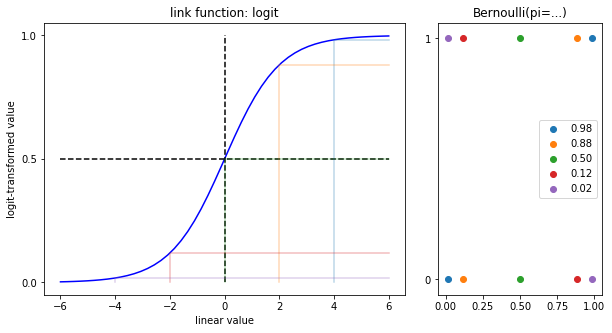

In [34]:
'''binomial distribution with logit link function; Bernoulli experiments'''
fig = plt.figure(figsize=(10, 5))
# --- 2 leftmost areas of 3x1 grid --- for function plot
ax_p = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax_p.plot(x_, y_, 'b-')
ax_p.plot([0, 0], [0, 1], 'k--')
ax_p.plot([-6, 6], [0.5, 0.5], 'k--')
ax_p.set_yticks([0, 0.5, 1])
ax_p.set_xlabel('linear value')
ax_p.set_ylabel('logit-transformed value')
ax_p.set_title('link function: logit')

# --- 1 rightmost area of 3x1 grid --- for marginals
ax_m = plt.subplot2grid((1, 3), (0, 2))
# subjects (one per age) (should be subjects within age range ...)
N = 1
xx = [-4, -2, 0, 2, 4]   # some example positions of interest
# possible outcomes of Bernoulli experiment
xm = np.arange(N+1)
# cycle trough examples
for xi in xx[::-1]:
    # 二项分布-
    # pmf: Probability mass function
    ym = stats.binom(N, logit(xi)).pmf(xm) # probabilities
    print('ym[{:2d}]:{}'.format(xi, ym))
    ax_m.scatter(ym, xm, label='{:.2f}'.format(logit(xi))) # in marginal-plot
    # connecting lines 连接线
    ax_p.plot([xi, xi, 6], [0]+2*[logit(xi)], alpha=.3)

ax_m.set_yticks([0, 1])
ax_m.set_title('Bernoulli(pi=...)')
ax_m.legend(loc='center right');


## Binomialverteilung
Wahrscheinlichkeitsverteilung der $y=$ *Anzahl der Erfolge* mehrerer Bernoulli-Ereignisse

$$P(y|N, \pi) = {N \choose y} \pi^y (1-\pi)^{(N-y)}\qquad y \in \{0\dots n\}$$

$$\mathcal{E}(y) = N\pi$$

xm:[0 1 2 3 4 5 6 7 8]
---
4:[1.09526011e-14 4.78393407e-12 9.14178825e-10 9.98249452e-08
 6.81282167e-06 2.97573968e-04 8.12349407e-03 1.26722214e-01
 8.64849805e-01]
---
2:[4.07657288e-08 2.40976206e-06 6.23205346e-05 9.20979853e-04
 8.50646475e-03 5.02837962e-02 1.85774895e-01 3.92200321e-01
 3.62248772e-01]
---
0:[0.00390625 0.03125    0.109375   0.21875    0.2734375  0.21875
 0.109375   0.03125    0.00390625]
---
-2:[3.62248772e-01 3.92200321e-01 1.85774895e-01 5.02837962e-02
 8.50646475e-03 9.20979853e-04 6.23205346e-05 2.40976206e-06
 4.07657288e-08]
---
-4:[8.64849805e-01 1.26722214e-01 8.12349407e-03 2.97573968e-04
 6.81282167e-06 9.98249452e-08 9.14178825e-10 4.78393407e-12
 1.09526011e-14]


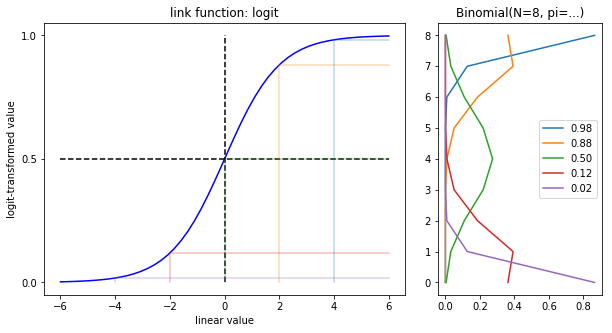

In [45]:
'''binomial distribution with logit link function; Binomial distribution'''
fig = plt.figure(figsize=(10, 5))
# --- 2 leftmost areas of 3x1 grid --- for function plot
ax_p = plt.subplot2grid((1, 3), (0, 0), colspan=2)             
ax_p.plot(x_, y_, 'b-')
ax_p.plot([0, 0], [0, 1], 'k--')
ax_p.plot([-6, 6], [0.5, 0.5], 'k--')
ax_p.set_yticks([0, 0.5, 1])
ax_p.set_xlabel('linear value')
ax_p.set_ylabel('logit-transformed value')
ax_p.set_title('link function: logit')

# --- 1 rightmost area of 3x1 grid --- for marginals
ax_m = plt.subplot2grid((1, 3), (0, 2))                         
N = 8 # subjects (one per age) (should be subjects within age range ...)
xx = [-4, -2, 0, 2, 4]   # some example positions
xm = np.arange(N+1) # possible outcomes of Bernoulli experiment
print('xm:{}'.format(xm))
for xi in xx[::-1]: # cycle trough examples
    ym = stats.binom(N, logit(xi)).pmf(xm) # probabilities
    print('---\n{}:{}'.format(xi,ym))
    # 在右图中画点散点
    ax_m.plot(ym, xm, label='{:.2f}'.format(logit(xi)))  # in marginal-plot
    # 在左图画连线
    ax_p.plot([xi, xi, 6], [0]+2*[logit(xi)], alpha=.3)  # connecting lines
    
ax_m.set_title('Binomial(N=8, pi=...)')
ax_m.legend(loc='center right');


## Ergebnis Link-Funktion
Eine Link Funktion $g(\mu)$
- kann Anforderungen an Randbedingungen von Zufallsvariablen erfüllen
    - $\infty$-Problem $\boldsymbol\checkmark$
    - Verteilung der Streuung berücksichtigen $\boldsymbol\checkmark$
- erweitert das Lineare Modell
    - verbindet lineare Vorhersage $\mathbf{x}_i^T \boldsymbol\beta$
    - und zentralen Parameter der Wahrscheinlichkeitsverteilung $\mu_i$

## (erstes) Ergebnis Generalisierte Lineare Modelle
$$g(\mu_i) = \mathbf{x}_i^T \boldsymbol\beta$$

$$\mathcal{E}(Y_i) = \mu_i = g^{-1}(\mathbf{x}_i^T \boldsymbol\beta)$$
$$Y_i \sim f(\mu_i, \sigma^2)$$

## Literatur 
- http://nbviewer.jupyter.org/github/tomwallis/glm-intro/blob/master/index.ipynb
- Dobson, Barnett: An Introduction to Generalized Linear Models. Chapman&Hall/CRC, 3rd ed. 2008
- McCullagh, Nelder: Generalized Linear Models. Chapman&Hall/CRC, 2nd ed. 1989


### Python statsmodels.glm
Methode `f_test` auf den ausgeführten Fit:

    fit = smf.glm(...).fit()
    restrict = [0, 1, 0]        # for example fix 2nd variable
    fit.f_test(restrict)

http://statsmodels.sourceforge.net/devel/dev/generated/statsmodels.base.model.GenericLikelihoodModelResults.f_test.html#statsmodels.base.model.GenericLikelihoodModelResults.f_test

# Fragen?